In [1]:
import sys, os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

pd.set_option('max_colwidth', 500)

%matplotlib inline

In [2]:
# read csv's
df_train = pd.read_csv('./challenge_train_.csv',index_col=0, memory_map=True)
df_test = pd.read_csv('./challenge_test_.csv', index_col=0, memory_map=True)

# Exporatory data analysis

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22500 entries, 0 to 22499
Data columns (total 2 columns):
text         22500 non-null object
sentiment    22500 non-null int64
dtypes: int64(1), object(1)
memory usage: 527.3+ KB


In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 22500 to 24999
Data columns (total 2 columns):
text         2500 non-null object
sentiment    0 non-null float64
dtypes: float64(1), object(1)
memory usage: 58.6+ KB


## Drop duplicates

### in _train_ set

In [5]:
print('duplicated rows: ',df_train.duplicated().sum())
df_train.drop_duplicates(inplace=True)

duplicated rows:  78


### in _test_ set

In [6]:
print('duplicated rows: ',df_test.duplicated().sum())
df_test.drop_duplicates(inplace=True)

duplicated rows:  0


### between  _train_ and _test_ set (I keep rows in _train_ set)

In [7]:
df_merge = df_train.merge(df_test.loc[:,'text'], on='text', )
print('text duplicated: {}'.format(df_merge.shape[0]))

df_test = df_test[~df_test.text.isin(df_merge.text)]

text duplicated: 18


## _sentiment_ labels 

In [8]:
df_train.head(5)

,text,sentiment
0,"Horrible film. About an old crusty painter who hangs around with a young girl. Boring. Tatum O Neil goes through the motions in her part, and has some of the corniest lines in film history. Richard Burton looks close to death in this film, and we're supposed to believe he looks ""Good for sixty"". The acting is bad, as is the plot. The characters are awful, as is the story. It's really hard to feel for anyone in this film, except Larry Ewashen who plays a guy in a porno theater who hits on Tat...",1
1,"This is the worst movie I've ever seen in my life. This is saying quite a bit, considering some of the choices I've made in film rentals. I got this on netflix based entirely on the fact that someone I went to high school with is topless in it. The topless scene lasted all of about 5 seconds and the rest of the movie was about as much fun as having pungee sticks driven underneath my toenails whilst being forced to listen to Roseanne sing Big Spender. The ""skits"" are stupid and consist of t...",1
2,"I was really, really disappointed with this movie. it started really well, and built up some great atmosphere and suspense, but when it finally got round to revealing the ""monster""...it turned out to be just some psycho with skin problems......again. Whoop-de-do. Yet another nutjob movie...like we don't already have enough of them. To be fair, the ""creep"" is genuinely unsettling to look at, and the way he moves and the strange sounds he makes are pretty creepy, but I'm sick of renting film ...",1
3,"Wow I loved this movie! It is about normal life in a small village. About hypocrisy and honesty, love and surrender. Great! It is about things everybody encounters in life. You have to do things with passion. But some people will not appreciate your passion and will try to stop you. There are people who find the opinion of others and 'what will the neighbors think' more important than to follow their heart. Don't let anybody's opinion stop you from fulfilling your dreams and passion. I loved...",0
4,"Gung Ho is one of those movies that you will want to see over and over again. Michael Keaton is put in charge of wooing a Japanese car company to come to his town thus creating jobs for the residents of Hadleyville. What happens after that is one hilarious moment after another. The two cultures clash and it is up to Keaton to hold things together. Look for great performances from Keaton, Gedde Watanabe, George Wendt, Mimi Rogers, John Turturro, Soh Yamamura and Sab Shimomo. All are perfectly...",0


In [9]:
dict_labels = {0:'good', 1:'bad'}

## _sentiment_ proportions in _train_ set

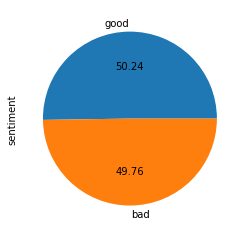

In [10]:
df_train.sentiment.value_counts().rename(dict_labels ,axis=0).plot.pie(autopct='%0.2f');

## _text_ lenght in  _train_ set

In [11]:
df_train.text.apply(len).describe()

count    22422.000000
mean      1304.725448
std        992.403398
min         52.000000
25%        694.000000
50%        963.000000
75%       1582.000000
max      13604.000000
Name: text, dtype: float64

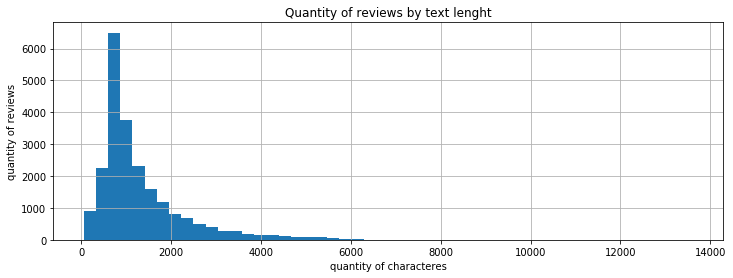

In [12]:
# df_train.text.apply(len).value_counts().hist(bins=50);
df_train.text.apply(len).hist(bins=50, figsize=[12,4]);
plt.xlabel('quantity of characteres')
plt.ylabel('quantity of reviews')
plt.title('Quantity of reviews by text lenght');

# ML model

## Text pre-processing

In [13]:
import string

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text
    text = [word for word in text.split(" ")]
    #  remove puncutation
    text = [word.strip(string.punctuation) for word in text]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]

    # join all
    text = " ".join(text)
    return(text)

In [14]:
df_train['clean_text'] = df_train['text'].apply(lambda x: clean_text(x))

In [15]:
X = df_train.clean_text
y = df_train.sentiment

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC())
])

parameters = {
    'vect__ngram_range': [(1, 2)],
#     'tfidf__use_idf': (True, False),
#     'clf__tol': [1e-4]
}

grid_clf = GridSearchCV(text_clf, parameters, cv=5, iid=False, n_jobs=-1, scoring='accuracy')

grid_clf = grid_clf.fit(X, y)

# for param_name in sorted(parameters.keys()):
#     print("{}: {}".format(param_name, gs_clf.best_params_[param_name]))

In [16]:
joblib.dump(grid_clf.best_estimator_, 'review_clf.pkl')

['review_clf.pkl']

# Estimated accuracy

In [17]:
print(grid_clf.best_score_)

0.9041564855395675


**best_score_** : float <br>
Mean cross-validated score of the best_estimator

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

# Sentiment predictions 

In [18]:
df_test['clean_text'] = df_test['text'].apply(lambda x: clean_text(x))

In [19]:
X_test = df_test.clean_text
y_pred = grid_clf.predict(X_test)

In [20]:
df_test.drop(columns=['sentiment'], inplace=True)
df_test['sentiment'] = y_pred

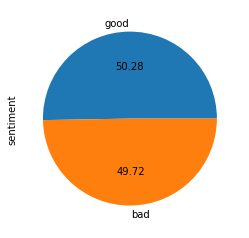

In [21]:
df_test.sentiment.value_counts().rename(dict_labels, axis=0).plot.pie(autopct='%0.2f');

In [22]:
df_test[['text', 'sentiment']].sort_index().to_csv('./test.csv')